C:\Users\pekkala\AppData\Local\Temp\ipykernel_23164\3424364310.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float_sun_zenith = float(sun_zenith_point)
C:\Users\pekkala\AppData\Local\Temp\ipykernel_23164\3424364310.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float_sun_azimuth = float(sun_azimuth_point)
C:\Users\pekkala\AppData\Local\Temp\ipykernel_23164\3424364310.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float_viewing_zenith = float(view

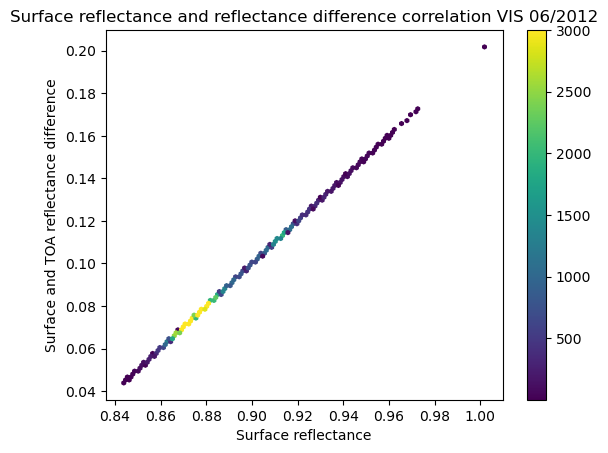

In [11]:
import sys 
import os
sys.path.append(os.path.abspath("path/SMAC-master/"))
import smac
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pyresample
import dask.dataframe as dd
import gc

#read the 49 coefficients in smac_soefs table
nom_smac ='path + /SMAC-master/COEFS/coef_NOAA18_VIS_CONT.dat'
#nom_smac ='K:/analyysi/SMAC2/SMAC-master/COEFS/coef_NOAA18_NIR_CONT.dat'
coefs=smac.coeff(nom_smac)
save_path = 'path'

#Open combined data
Foo_timeseries = xr.open_dataset('path + file')

#Calculate mean over time timension
timeseries_mean_in_time_201206 = Foo_timeseries.mean(('time'))


#Define lists for results
r_surf_list = []
r_diff_list = []
sun_az_list = []
surface_pressure = []

for x in range(1, 360):
    for y in range(1, 360):
        Foo_point = timeseries_mean_in_time_201206.sel(x=slice(x-1, x), y=slice(y-1, y))

        try:


            #read the angle values in the image metadata and compute these values
            
            sun_zenith_point = Foo_point['sun_zenith'].values
            float_sun_zenith = float(sun_zenith_point)
            theta_s = float_sun_zenith #solar zenith angle

            sun_azimuth_point = Foo_point['sun_azimuth'].values
            float_sun_azimuth = float(sun_azimuth_point)
            phi_s = float_sun_azimuth #solar azimuth angle
            

            viewing_zenith_point = Foo_point['satellite_zenith'].values
            float_viewing_zenith = float(viewing_zenith_point)
            theta_v = float_viewing_zenith  #viewing zenith 


            viewing_azimuth_point = Foo_point['satellite_azimuth']
            float_viewing_azimuth = float(viewing_azimuth_point)
            phi_v = float_viewing_azimuth  #viewing azimuth angle


            
            # compute pressure at pixel altitude (in m)

            surface_pressure = Foo_point['Surface_pressure']
            float_surface_pressure = float(surface_pressure)
            pressure = float_surface_pressure



            
            #find the values of AOT, UO3, UH2O
            
            
            AOT550=0.07 # AOT at 550 nm

     
            Ozone = Foo_point['Ozone']    # Ozone content (cm)  0.3 cm= 300 Dobson Units
            float_UO3 = float(Ozone)
            UO3 = float_UO3


            Water_vapour = Foo_point['Water_vapour']
            float_water_vapour = float(Water_vapour)
            UH2O = float_water_vapour     # Water vapour (g/cm2)
            


            r_toa = # 0.8 for VIS and 06 for NIR





            
            #compute the atmospheric correction
            r_surf=smac.smac_inv(r_toa,theta_s,phi_s,theta_v,phi_v,pressure,AOT550,UO3,UH2O,coefs)
            r_surf_list.append(r_surf)
            
            r_diff = r_surf-r_toa
            r_diff_list.append(r_diff)

            gc.collect()
            

            

        except Exception:
            print("Error", "(x,x) = ", (x-1, x), "(y,y) = ", (y-1, y))

        continue


#Plot hexbin graph

plt.hexbin(r_surf_list, r_diff_list, mincnt=1, vmax=3000) # x,y
plt.colorbar()
plt.title('Surface reflectance and reflectance difference correlation VIS 06/2012')
plt.xlabel('Surface reflectance')
plt.ylabel('Surface and TOA reflectance difference')
plt.savefig(save_path + 'SAL_x_and_diff_y_reflectance_correlation_VIS_3_grid_201206_plot2.png')







Save r_surf list in a txt file

In [14]:
with open(save_path + 'VIS201206_rsurf.txt', 'a') as outfile:
    outfile.writelines((str(i)+'\n' for i in r_surf_list))